# load data

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import os.path as osp
from tqdm import tqdm

In [2]:
N = 6111
dir_name = './data/'
datasets = []
for i in tqdm(range(N)):
	data = torch.load(osp.join(dir_name,f'data_{i}.pt'))
	datasets.append(data)

100%|██████████| 6111/6111 [04:23<00:00, 23.23it/s]


## train-test split

In [3]:
train_idx = list()
test_name = list()
test_idx = list()
y_train = list()
with open('./data/raw/graph_labels.txt', 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            test_name.append(t[0])
            test_idx.append(i)
        else:
            train_idx.append(i)
            y_train.append(int(t[1][:-1]))

In [4]:
len(train_idx),len(test_idx)

(4888, 1223)

In [5]:
train_val_set = [datasets[i] for i in train_idx]
test_set = [datasets[i] for i in test_idx]

## add sequential encodings

In [6]:
import pickle
with open('./embedding/X_train_esm_embedding_AA', 'rb') as f:
	train_sequential_embeddings = pickle.load(f)
with open('./embedding/X_test_esm_embedding_AA', 'rb') as f:
	test_sequential_embeddings = pickle.load(f)

In [8]:
len(train_sequential_embeddings), len(test_sequential_embeddings)

(4888, 1223)

sequential embedding contains a beginning and an ending

In [12]:
train_val_set[0].x.shape

torch.Size([185, 86])

In [ ]:
for train_data in enumerate(train_val_set):
	train_data.x

## add label

In [6]:
for data, y in zip(train_val_set, y_train):
	data.y = y

## train-valid split

In [7]:
train_set, val_set = torch.utils.data.random_split(train_val_set, [0.9,0.1], generator=torch.Generator().manual_seed(42))

In [8]:
len(train_set), len(val_set)

(4400, 488)

## Hyperparameters

In [9]:
import numpy as np
num_node_features = train_set[0].num_node_features # 86
print(num_node_features)
num_classes = len(np.unique(y_train)) # 18
print(num_classes)
lr = 1e-3
epochs = 100
batch_size = 32
hidden_dim = 64

86
18


## Dataloader

In [10]:
from torch.utils.data.dataloader import default_collate
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
collate_fn = lambda x: tuple(x_.to(device) for x_ in default_collate(x))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [11]:
train_val_loader =DataLoader(train_val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [12]:
for step, data in enumerate(train_loader):
	print(f'Step {step + 1}:')
	print('=======')
	print(f'Number of graphs in the current batch: {data.num_graphs}')
	print(data.is_cuda)
	print()
	break

Step 1:
Number of graphs in the current batch: 32
False



In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.utils import dropout_node

# GNN0: baseline

In [17]:
class GCN_0(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_0, self).__init__()
        torch.manual_seed(12345)
        self.p = 0.2
        self.conv1 = gnn.GCNConv(num_node_features, hidden_channels)
        self.conv2 = gnn.GCNConv(hidden_channels, hidden_channels)
        self.bn = gnn.BatchNorm(hidden_channels)
        self.dropout = nn.Dropout(self.p)
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        edge_index = dropout_node(edge_index)[0] # edge_index, edge_mask, node_mask
        x = self.conv2(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = gnn.global_add_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.bn(x)
        x = x.relu()
        embedding = x

        # 3. Apply a final classifier
        x = self.lin1(x)
        x = x.relu()
        
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.lin2(x)
        
        return F.log_softmax(x, dim=1), embedding

In [26]:
model_0 = GCN_0(hidden_channels=hidden_dim).to(device)
print(model_0)
optimizer_0 = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

GCN_0(
  (conv1): GCNConv(86, 128)
  (conv2): GCNConv(128, 128)
  (bn): BatchNorm(128)
  (dropout): Dropout(p=0.2, inplace=False)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=18, bias=True)
)


In [44]:
def train(model, optimizer):
	model.train()
	for data in tqdm(train_loader):
		data = data.to(device)
		out,_ = model(data.x, data.edge_index, data.edge_attr, data.batch)
		loss = criterion(out, data.y)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()

def eval(model, loader):
	model.eval()
	correct = 0
	for data in loader:
		data = data.to(device)
		out,_ = model(data.x, data.edge_index, data.edge_attr, data.batch)
		loss = criterion(out, data.y)
		pred = out.argmax(dim=1)
		correct += int((pred == data.y).sum())
		acc = correct / len(loader.dataset)
	return acc, loss

def predict(model):
	pred_proba = []
	model.eval()
	for data in test_loader:
		data = data.to(device)
		out,_ = model(data.x, data.edge_index, data.edge_attr, data.batch)
		pred_proba.append(out.detach().cpu().numpy())
		del out
		torch.cuda.empty_cache()
	pred_proba = np.vstack(pred_proba)
	pred_proba = np.exp(pred_proba)
	return pred_proba

def embed(model, loader):
	embeddings = []
	model.eval()
	for data in loader:
		data = data.to(device)
		_, embedding = model(data.x, data.edge_index, data.edge_attr, data.batch)
		embeddings.append(embedding.detach().cpu().numpy())
		del embedding
		torch.cuda.empty_cache()
	embeddings = np.vstack(embeddings)
	return embeddings

### load & save checkpoint 

In [14]:
import os.path as osp
from tabnanny import check
def load_checkpoint(model, optimizer, path):
	if osp.exists(path):
		checkpoint = torch.load(path)
		model.load_state_dict(checkpoint['model_state_dict'])
		optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
		print('checkpoint loaded')
		return checkpoint.get('loss')

In [15]:
def save_checkpoint(model, optimizer, loss, path):
	torch.save({
							'epoch': epochs,
							'model_state_dict': model.state_dict(),
							'optimizer_state_dict': optimizer.state_dict(),
							'loss': loss,
							}, path)

### train epochs and save checkpoints

In [24]:
import time
def train_epochs(model, optimizer, path, patience=10, from_scratch=True):
	checkpoint_loss = None
	if not from_scratch:
		checkpoint_loss = load_checkpoint(model, optimizer, path=path)
	best_val_loss = checkpoint_loss if checkpoint_loss else 2.8 #2.8 is the loss of equi-ignorant guess
	best_val_acc = 0
	for epoch in range(epochs):
		train(model, optimizer)
		train_acc, train_loss = eval(model, train_loader)
		val_acc, val_loss = eval(model, val_loader)
		print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
		if val_loss < best_val_loss:
			save_checkpoint(model, optimizer, loss=val_loss, path=path)
			best_val_loss = val_loss
			print('checkpoint saved')
			patience = patience
		else:
			patience -= 1
			if patience == 0:
				print('early stopping')
				break

In [25]:
def train_epochs_full(model, optimizer, path, patience=10, from_scratch=True):
	checkpoint_loss = None
	if not from_scratch:
		checkpoint_loss = load_checkpoint(model, optimizer, path=path)
	best_train_loss = checkpoint_loss if checkpoint_loss else 2.8 #2.8 is the loss of equi-ignorant guess
	best_train_acc = 0
	for epoch in range(epochs):
		train(model, optimizer)
		train_acc, train_loss = eval(model, train_val_loader)
		time.sleep(0.5)
		print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
		if train_loss < best_train_loss:
			save_checkpoint(model, optimizer, loss=train_loss, path=path)
			best_train_loss = train_loss
			print('checkpoint saved')
			patience = patience
		else:
			patience -= 1
			if patience == 0:
				print('early stopping')
				break

training sample model for over 150 epochs, no significant improvement. we keep the 100 epochs checkpoint.

retrain model together with validation data

In [48]:
model_0_full = GCN_0(hidden_channels=hidden_dim).to(device)
print(model_0_full)
optimizer_0_full = torch.optim.Adam(model_0_full.parameters(), lr=lr)

GCN_0(
  (conv1): GCNConv(86, 128)
  (conv2): GCNConv(128, 128)
  (bn): BatchNorm(128)
  (dropout): Dropout(p=0.2, inplace=False)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=18, bias=True)
)


### load checkpoint and predict

In [52]:
PATH = './model/model_0.pt'
PATH_full = './model/model_0_full.pt'
load_checkpoint(model_0, optimizer_0, PATH)
load_checkpoint(model_0_full, optimizer_0_full, PATH_full)

checkpoint loaded
checkpoint loaded


tensor(1.4219, device='cuda:0', requires_grad=True)

### write

In [18]:
import csv
def write_csv(fname, pred_proba):
    with open(f'./prediction/{fname}.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        lst = list()
        for i in range(18):
            lst.append('class'+str(i))
        lst.insert(0, "name")
        writer.writerow(lst)
        for i, protein in enumerate(test_name):
            lst = pred_proba[i,:].tolist()
            lst.insert(0, protein)
            writer.writerow(lst)

In [45]:
pred_proba_0 = predict(model_0)
write_csv('gnn0',pred_proba_0)


In [53]:
write_csv('gnn0_full', predict(model_0_full))

# GNN1: GAT

In [46]:
class GAT_1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT_1, self).__init__()
        torch.manual_seed(12345)
        self.p = 0.2
        self.bn = gnn.BatchNorm(hidden_channels)
        self.gat = gnn.GAT(in_channels=num_node_features, 
                            hidden_channels=hidden_channels,
                            num_layers=2,
                            heads = 4,
                            concat = True,
                            dropout= 0.2,
                            add_self_loops=False,
                            norm=self.bn,
                            edge_dim=5)
        self.lin = gnn.MLP(in_channels=hidden_channels, 
                            hidden_channels=hidden_channels,
                            out_channels=num_classes, 
                            num_layers=2, 
                            dropout=0.2)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat(x=x, edge_index=edge_index, 
                    #edge_attr=edge_attr
                    )
        x = gnn.global_add_pool(x, batch)
        x = self.bn(x)
        x = x.relu()
        emb = x
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1), emb

In [47]:
model_1 = GAT_1(hidden_channels=64).to(device)
print(model_1)
optimizer_1 = torch.optim.Adam(model_1.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

GAT_1(
  (bn): BatchNorm(64)
  (gat): GAT(86, 64, num_layers=2)
  (lin): MLP(64, 64, 18)
)


In [ ]:
train_epochs(model_1, optimizer_1, path='./model/model_1.1.pt', patience = 50, from_scratch=True)

In [53]:
train_epochs_full(model_1, optimizer_1, path='./model/model_1.pt', patience=50)

checkpoint loaded


100%|██████████| 138/138 [00:06<00:00, 20.16it/s]


Epoch: 000, Train Loss: 1.1760, Train Acc: 0.4626


100%|██████████| 138/138 [00:06<00:00, 20.71it/s]


Epoch: 001, Train Loss: 1.9339, Train Acc: 0.4198


100%|██████████| 138/138 [00:06<00:00, 20.71it/s]


Epoch: 002, Train Loss: 1.5893, Train Acc: 0.5233


100%|██████████| 138/138 [00:06<00:00, 20.82it/s]


Epoch: 003, Train Loss: 1.6880, Train Acc: 0.3809


100%|██████████| 138/138 [00:06<00:00, 20.63it/s]


Epoch: 004, Train Loss: 1.5173, Train Acc: 0.5153


100%|██████████| 138/138 [00:06<00:00, 20.17it/s]


Epoch: 005, Train Loss: 2.1446, Train Acc: 0.4452


100%|██████████| 138/138 [00:06<00:00, 20.97it/s]


Epoch: 006, Train Loss: 1.7478, Train Acc: 0.5113


100%|██████████| 138/138 [00:06<00:00, 21.33it/s]


Epoch: 007, Train Loss: 1.6105, Train Acc: 0.4327


100%|██████████| 138/138 [00:06<00:00, 21.50it/s]


Epoch: 008, Train Loss: 1.4771, Train Acc: 0.4943


100%|██████████| 138/138 [00:06<00:00, 21.23it/s]


Epoch: 009, Train Loss: 1.7092, Train Acc: 0.4726


100%|██████████| 138/138 [00:06<00:00, 21.12it/s]


Epoch: 010, Train Loss: 1.1470, Train Acc: 0.5794


100%|██████████| 138/138 [00:06<00:00, 21.15it/s]


Epoch: 011, Train Loss: 1.6931, Train Acc: 0.4996


100%|██████████| 138/138 [00:06<00:00, 21.79it/s]


Epoch: 012, Train Loss: 1.2031, Train Acc: 0.5350


100%|██████████| 138/138 [00:06<00:00, 20.75it/s]


Epoch: 013, Train Loss: 1.5650, Train Acc: 0.4849


100%|██████████| 138/138 [00:06<00:00, 21.34it/s]


Epoch: 014, Train Loss: 2.1397, Train Acc: 0.4251


100%|██████████| 138/138 [00:06<00:00, 20.93it/s]


Epoch: 015, Train Loss: 1.5332, Train Acc: 0.5110


100%|██████████| 138/138 [00:06<00:00, 20.85it/s]


Epoch: 016, Train Loss: 2.1813, Train Acc: 0.5031


100%|██████████| 138/138 [00:06<00:00, 20.31it/s]


Epoch: 017, Train Loss: 1.3115, Train Acc: 0.5816


100%|██████████| 138/138 [00:06<00:00, 20.92it/s]


Epoch: 018, Train Loss: 1.6000, Train Acc: 0.5016


100%|██████████| 138/138 [00:06<00:00, 20.93it/s]


Epoch: 019, Train Loss: 2.0276, Train Acc: 0.5219


100%|██████████| 138/138 [00:06<00:00, 20.89it/s]


Epoch: 020, Train Loss: 1.4943, Train Acc: 0.5115


100%|██████████| 138/138 [00:06<00:00, 22.07it/s]


Epoch: 021, Train Loss: 1.3818, Train Acc: 0.4689


100%|██████████| 138/138 [00:06<00:00, 22.31it/s]


Epoch: 022, Train Loss: 1.9888, Train Acc: 0.4767


100%|██████████| 138/138 [00:06<00:00, 22.11it/s]


Epoch: 023, Train Loss: 1.1106, Train Acc: 0.5405


100%|██████████| 138/138 [00:06<00:00, 22.55it/s]


Epoch: 024, Train Loss: 1.4082, Train Acc: 0.5063


100%|██████████| 138/138 [00:06<00:00, 22.34it/s]


Epoch: 025, Train Loss: 1.6005, Train Acc: 0.5047


100%|██████████| 138/138 [00:06<00:00, 22.52it/s]


Epoch: 026, Train Loss: 1.5139, Train Acc: 0.4977


100%|██████████| 138/138 [00:06<00:00, 22.46it/s]


Epoch: 027, Train Loss: 1.2414, Train Acc: 0.5166


100%|██████████| 138/138 [00:06<00:00, 22.27it/s]


Epoch: 028, Train Loss: 1.6064, Train Acc: 0.5403


100%|██████████| 138/138 [00:06<00:00, 22.44it/s]


Epoch: 029, Train Loss: 1.2338, Train Acc: 0.4685


100%|██████████| 138/138 [00:06<00:00, 22.51it/s]


Epoch: 030, Train Loss: 1.2777, Train Acc: 0.4642


100%|██████████| 138/138 [00:06<00:00, 22.53it/s]


Epoch: 031, Train Loss: 1.4078, Train Acc: 0.5254


100%|██████████| 138/138 [00:06<00:00, 22.75it/s]


Epoch: 032, Train Loss: 2.7376, Train Acc: 0.4671


100%|██████████| 138/138 [00:06<00:00, 22.25it/s]


Epoch: 033, Train Loss: 3.3368, Train Acc: 0.5278


100%|██████████| 138/138 [00:06<00:00, 22.55it/s]


Epoch: 034, Train Loss: 1.2589, Train Acc: 0.5597


100%|██████████| 138/138 [00:06<00:00, 22.50it/s]


Epoch: 035, Train Loss: 1.3557, Train Acc: 0.5468


100%|██████████| 138/138 [00:06<00:00, 22.51it/s]


Epoch: 036, Train Loss: 1.1377, Train Acc: 0.5333


100%|██████████| 138/138 [00:06<00:00, 22.49it/s]


Epoch: 037, Train Loss: 1.6966, Train Acc: 0.4673


100%|██████████| 138/138 [00:06<00:00, 22.56it/s]


Epoch: 038, Train Loss: 1.5359, Train Acc: 0.5168


100%|██████████| 138/138 [00:06<00:00, 22.55it/s]


Epoch: 039, Train Loss: 1.6255, Train Acc: 0.5147


100%|██████████| 138/138 [00:06<00:00, 22.46it/s]


Epoch: 040, Train Loss: 1.9601, Train Acc: 0.4464


100%|██████████| 138/138 [00:06<00:00, 22.48it/s]


Epoch: 041, Train Loss: 1.5503, Train Acc: 0.4550


100%|██████████| 138/138 [00:06<00:00, 22.77it/s]


Epoch: 042, Train Loss: 1.3939, Train Acc: 0.4932


100%|██████████| 138/138 [00:06<00:00, 22.67it/s]


Epoch: 043, Train Loss: 2.0074, Train Acc: 0.4740


100%|██████████| 138/138 [00:06<00:00, 22.68it/s]


Epoch: 044, Train Loss: 1.6658, Train Acc: 0.5016


100%|██████████| 138/138 [00:06<00:00, 22.80it/s]


Epoch: 045, Train Loss: 1.4669, Train Acc: 0.5366


100%|██████████| 138/138 [00:06<00:00, 22.62it/s]


Epoch: 046, Train Loss: 1.1959, Train Acc: 0.5366


100%|██████████| 138/138 [00:06<00:00, 22.43it/s]


Epoch: 047, Train Loss: 1.5486, Train Acc: 0.4898


100%|██████████| 138/138 [00:06<00:00, 22.27it/s]


Epoch: 048, Train Loss: 1.6675, Train Acc: 0.4816


100%|██████████| 138/138 [00:06<00:00, 22.19it/s]


Epoch: 049, Train Loss: 1.5092, Train Acc: 0.5489
early stopping


In [54]:
write_csv('gnn1',predict(model_1))

In [49]:
load_checkpoint(model_1, optimizer_1, path='./model/model_1.pt')
write_csv('gnn1',predict(model_1))

checkpoint loaded


In [36]:
import gc
def clean_gpu_memory():
	gc.collect()
	torch.cuda.empty_cache()

# embedding

In [48]:
load_checkpoint(model_1, optimizer_1, path='./model/model_1.pt')
train_val_embeddings = embed(model_1, train_val_loader)
test_embeddings = embed(model_1, test_loader)

checkpoint loaded


In [49]:
train_val_embeddings.shape, test_embeddings.shape

((4888, 64), (1223, 64))

In [50]:
np.save('./embedding/train_structrual_embedding', train_val_embeddings)
np.save('./embedding/test_structrual_embedding', test_embeddings)

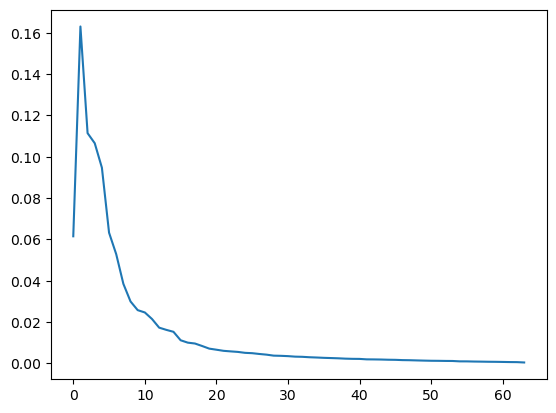

In [53]:
from matplotlib.pyplot import plot
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
X = np.vstack((train_val_embeddings, test_embeddings))
X_sparse = sp.csr_matrix(X)
svd = TruncatedSVD(n_components=64)
svd.fit(X)
plot(svd.explained_variance_ratio_)

# GNN2: GIN

In [ ]:
class GIN_2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GIN_2, self).__init__()
        torch.manual_seed(12345)
        self.p = 0.2
        self.bn = gnn.BatchNorm(hidden_channels)
        self.gin = gnn.GIN(in_channels=num_node_features, 
                            hidden_channels=hidden_channels,
                            num_layers=2,
                            dropout= 0.2,
                            norm=self.bn,
                            )
        self.lin = gnn.MLP(in_channels=hidden_channels, 
                            hidden_channels=hidden_channels,
                            out_channels=num_classes, 
                            num_layers=2, 
                            dropout=0.2)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gin(x=x, edge_index=edge_index, 
                    #edge_attr=edge_attr
                    )
        x = gnn.(x, batch)
        x = self.bn(x)
        x = x.relu()
        emb = x
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1), emb